In [23]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

In [24]:
df = pd.read_csv("filtered_data.csv")

# --- 1. Data Cleaning and Preparation ---

# Identify grouping and time columns
GROUP_COLUMN = 'Capitaline Code'
TIME_COLUMN = 'Year'

/tmp/ipython-input-3144948761.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("filtered_data.csv")


In [25]:
# Drop potential non-data rows (like disclaimers)
if 'Disclaimer' in str(df.iloc[-1]):
    df = df.iloc[:-1]

# Identify all numerical columns (potential ratios)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
id_and_year_cols = [GROUP_COLUMN, TIME_COLUMN]
ratio_cols = [col for col in numerical_cols if col not in id_and_year_cols and col not in ['Financial Year End', 'BSE Code']]

# Convert all ratio columns to numeric, coercing errors
for col in ratio_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [26]:
# --- 2. Feature Engineering: Creating Lagged Features (X) ---

# Sort the data by company and year to ensure proper lagging
df.sort_values(by=[GROUP_COLUMN, TIME_COLUMN], inplace=True)

# Create lagged features (Shift by 1 year) for all ratios
for col in ratio_cols:
    # Use a group-wise shift (lag-1) to get the previous year's value
    df[f'Lag_1_{col}'] = df.groupby(GROUP_COLUMN)[col].shift(1)
# All lagged columns will be our features (X)
feature_cols = [f'Lag_1_{col}' for col in ratio_cols]

# Filter out rows where the lagged features are NaN (i.e., the first year for each company)
df_model = df.dropna(subset=feature_cols).copy()

In [27]:
# --- 3. Prepare Training and Prediction Datasets ---

# 3a. Training Data (X_train and y_train for each target)
X_train = df_model[feature_cols]

# 3b. 2025 Prediction Input Data
# Select the latest data available (Year 2024) for each company
df_2024 = df.loc[df.groupby(GROUP_COLUMN)[TIME_COLUMN].idxmax()].copy()
df_2024 = df_2024[df_2024[TIME_COLUMN] == 2024] # Ensure we only use the 2024 data for prediction
X_2025_predict = df_2024[feature_cols]

In [28]:
# Store company identifiers for the final output
prediction_output = df_2024[['Company Name', GROUP_COLUMN]].reset_index(drop=True)
prediction_output.set_index([GROUP_COLUMN, 'Company Name'], inplace=True)


In [29]:
# --- 4. Training and Prediction Loop for All Ratios ---

print("Training models and predicting 2025 values for all financial ratios...")

for target_col in ratio_cols:
    # 4a. Select the target variable (Y) for this iteration
    y_train = df_model[target_col]

    # Drop rows where y_train contains NaN, infinity or values too large
    finite_mask = np.isfinite(y_train)
    X_train_filtered = X_train[finite_mask]
    y_train_filtered = y_train[finite_mask]

    # 4b. Initialize and Train the XGBoost model
    # Use a pipeline to scale features before feeding them to XGBoost
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(
            objective='reg:squarederror', # Corrected objective function name
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Fit the model
    pipeline.fit(X_train_filtered, y_train_filtered)

    # 4c. Generate Predictions for 2025
    y_2025_pred = pipeline.predict(X_2025_predict)

    # 4d. Store the predictions in the output DataFrame
    prediction_output[f'Predicted {target_col} (2025)'] = y_2025_pred

print("Done.")
prediction_output.reset_index(inplace=True)
prediction_output = prediction_output.drop(columns=[GROUP_COLUMN])

Training models and predicting 2025 values for all financial ratios...
Done.


1. Loading and cleaning data...


/tmp/ipython-input-3210314568.py:25: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("filtered_data.csv")


2. Engineering lagged features...
3. Training and predicting 2025 values for all financial ratios...
Prediction complete. Predicted values for 2025 for 3i Infotech:
  Net Working Capital ( Incl. Def. Tax): -608.57
  Debt-Equity Ratio: 0.14
  Long Term Debt-Equity Ratio: -0.39
  Current Ratio: 0.32
  Interest Cover Ratio: 2.87
  ROCE (%): 4.87
  PBIDTM (%): 17.71
  PBITM (%): 8.33
  APATM (%): -6.21
  RONW (%): 3.80
  ROE (X): 0.16
  EPS (annualised) (Unit Curr): -0.65
  Net Sales: 310.94
  Gross Sales: 360.49
  Value Of Output: 291.58
  Price to Book Value ( P/BV): 0.38
  Price Earning (P/E): 31.01
  EV/EBIDTA: 9.32
  Market Cap/Sales: 0.62
  Book Value: -30.95
  Cash Flow From Operating Activities: 61.10
  Total Income: 390.81
  Gross Profit: 48.02

4. Generating plots...

5. Visualization saved to 3i Infotech_all_ratios_XGBoost_predictions.png. The charts should be displayed below in Colab.


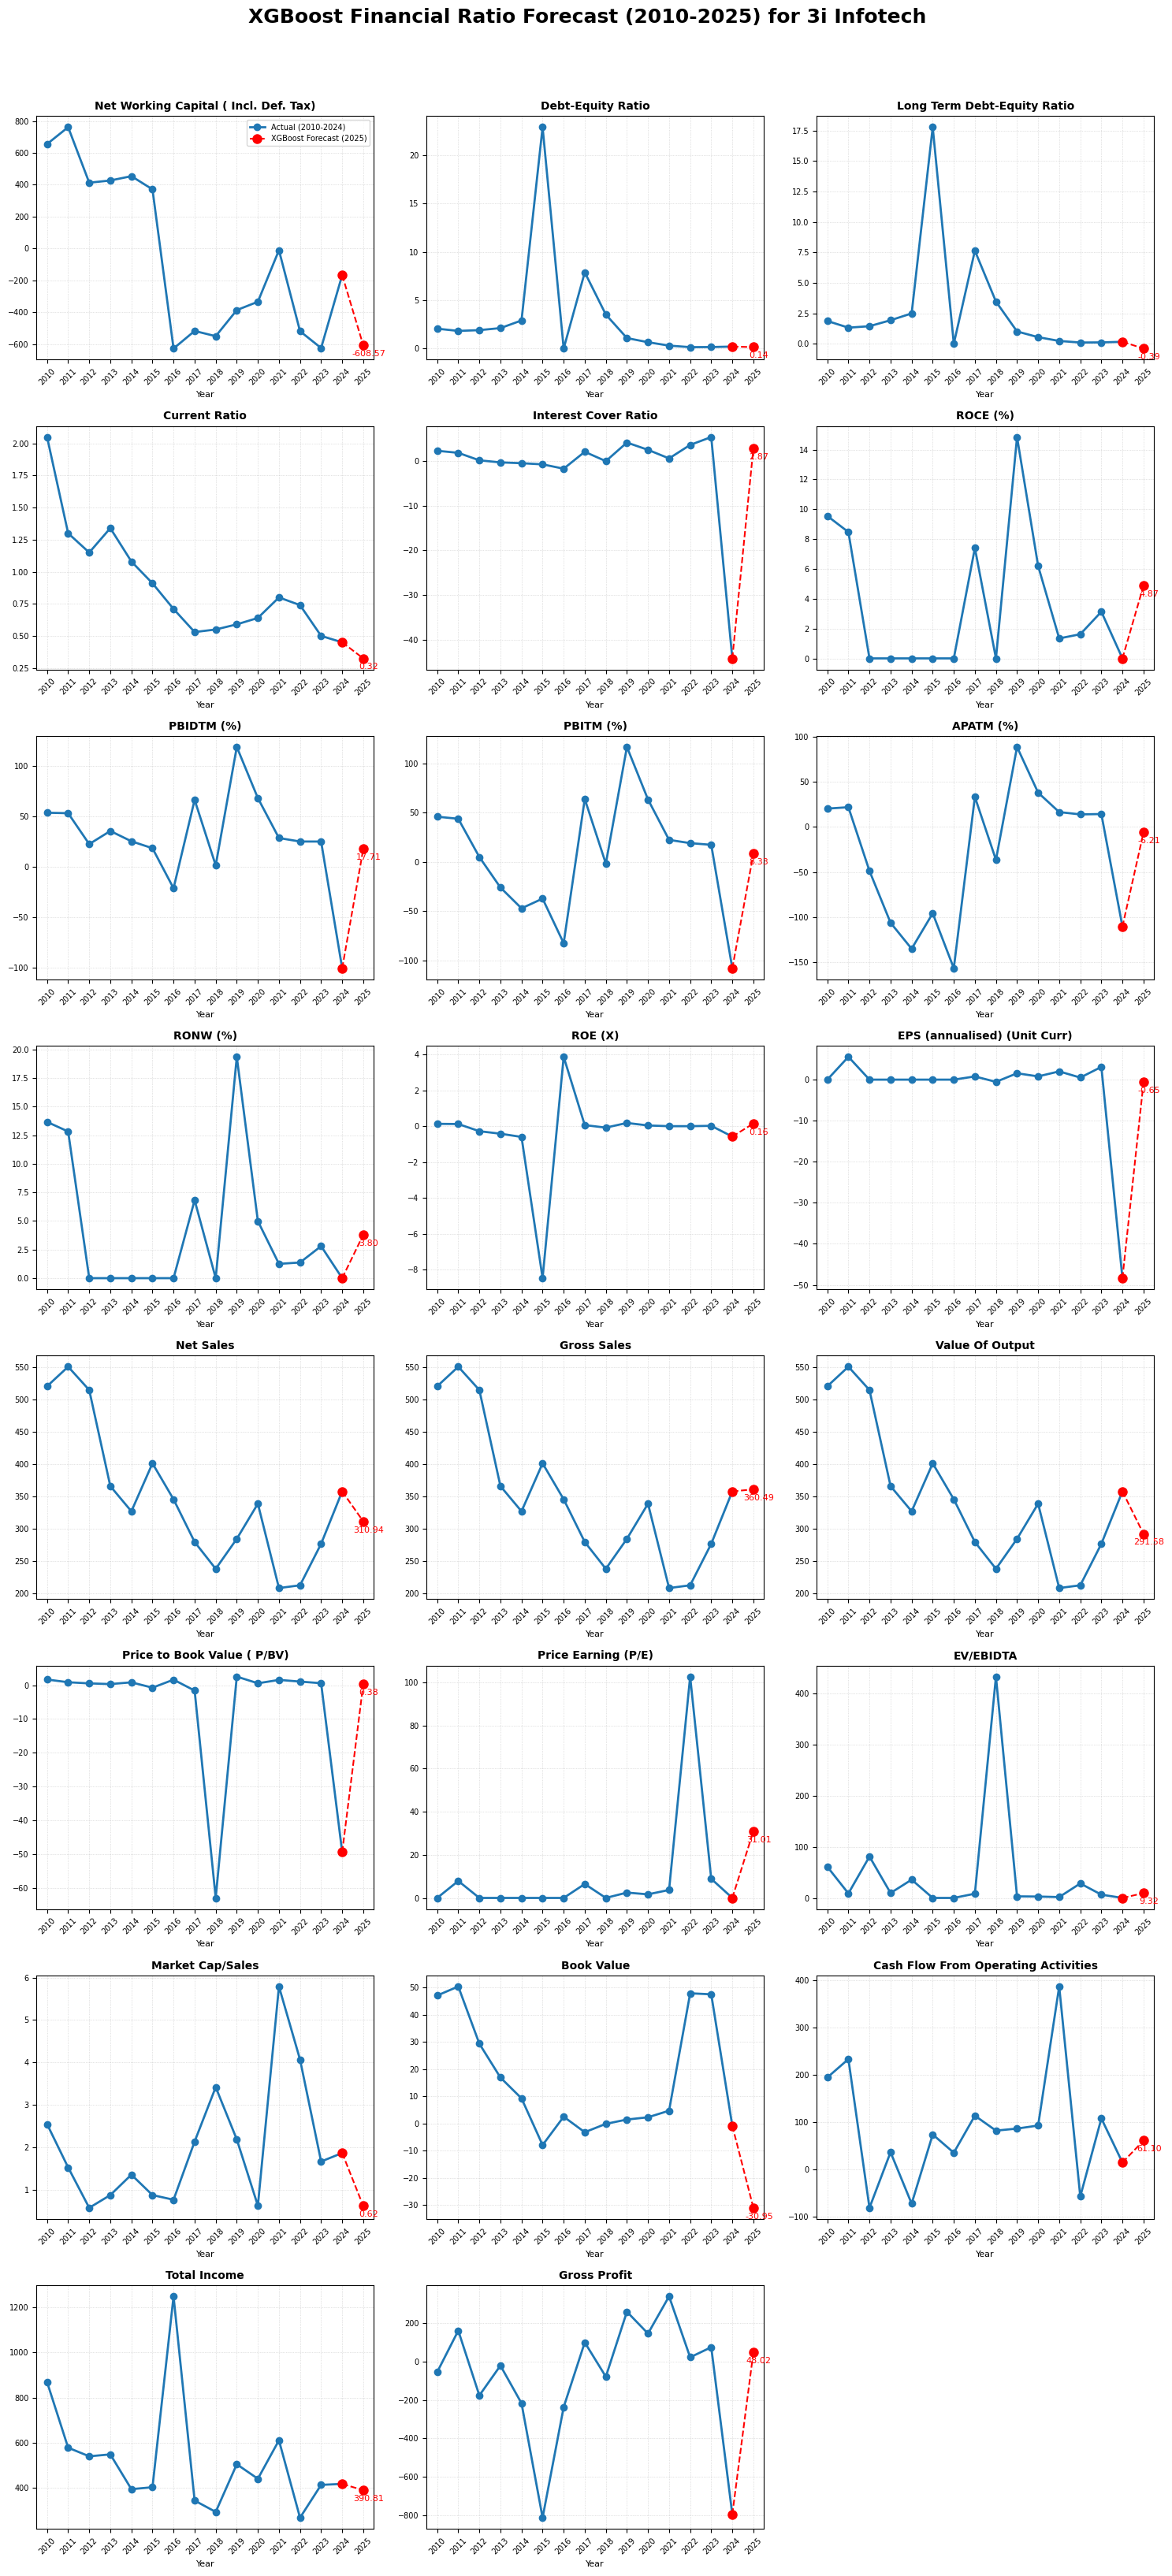

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# --- Configuration Section ---
# Set the name of the company you want to analyze and plot.
# Example: "20 Microns"
TARGET_COMPANY_NAME = "3i Infotech"

# --- Column Definitions ---
GROUP_COLUMN = 'Capitaline Code'
TIME_COLUMN = 'Year'
COMPANY_COLUMN = 'Company Name'
# Define columns to exclude from being treated as financial ratios (features or targets)
NON_RATIO_COLS = [GROUP_COLUMN, TIME_COLUMN, COMPANY_COLUMN, 'Financial Year End', 'BSE Code', 'NSE Symbol', 'Sector', 'Industry', 'Listing Status(MCX)']

# --- 1. Data Loading and Preprocessing ---
print("1. Loading and cleaning data...")

# Assuming filtered_data.csv is uploaded to your Colab environment
try:
    df = pd.read_csv("filtered_data.csv")
except FileNotFoundError:
    print("Error: 'filtered_data.csv' not found. Please upload it to your Colab session.")
    exit()

# Drop potential non-data rows
if 'Disclaimer' in str(df.iloc[-1]):
    df = df.iloc[:-1]

# Identify all numerical columns (potential ratios)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
ratio_cols = [col for col in numerical_cols if col not in NON_RATIO_COLS]

# Convert all ratio columns to numeric, coercing errors
for col in ratio_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Sort data for proper time-series operations
df.sort_values(by=[GROUP_COLUMN, TIME_COLUMN], inplace=True)


# --- 2. Feature Engineering: Creating Lagged Features (X) ---
print("2. Engineering lagged features...")

# Create lagged features (Shift by 1 year) for all ratios
for col in ratio_cols:
    # Use a group-wise shift (lag-1) to get the previous year's value
    df[f'Lag_1_{col}'] = df.groupby(GROUP_COLUMN)[col].shift(1)

# All lagged columns will be our features (X)
feature_cols = [f'Lag_1_{col}' for col in ratio_cols]

# Filter out rows where the lagged features are NaN (i.e., the first year for each company)
df_model = df.dropna(subset=feature_cols).copy()


# --- 3. Prepare Training and Prediction Datasets ---

# Training Features (X_train)
X_train = df_model[feature_cols]

# 2025 Prediction Input Data (X_predict)
# Select the latest data available (Year 2024) for each company
df_2024 = df.loc[df.groupby(GROUP_COLUMN)[TIME_COLUMN].idxmax()].copy()
df_2024 = df_2024[df_2024[TIME_COLUMN] == 2024]

# Check if the target company has 2024 data
target_company_2024_data = df_2024[df_2024[COMPANY_COLUMN] == TARGET_COMPANY_NAME]

if target_company_2024_data.empty:
    print(f"\nError: Could not find 2024 data for '{TARGET_COMPANY_NAME}'. Cannot generate 2025 prediction.")
    print("Please check the spelling or choose a company with data up to 2024.")
    exit()

X_predict_target_company = target_company_2024_data[feature_cols]
predicted_2025_values = {}


# --- 4. Training and Prediction Loop for All Ratios ---
print("3. Training and predicting 2025 values for all financial ratios...")

for target_col in ratio_cols:
    # Select the target variable (Y) for this iteration
    y_train = df_model[target_col]

    # Drop rows where y_train contains NaN, infinity or values too large
    finite_mask = np.isfinite(y_train)
    X_train_filtered = X_train[finite_mask]
    y_train_filtered = y_train[finite_mask]


    # Initialize and Train the XGBoost model
    # We use a pipeline for feature scaling (good practice, though less critical for XGBoost)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        ))
    ])

    # Fit the model
    pipeline.fit(X_train_filtered, y_train_filtered)

    # Generate Predictions for 2025 for the target company
    y_2025_pred = pipeline.predict(X_predict_target_company)

    # Store the predicted value
    predicted_2025_values[target_col] = y_2025_pred[0]

print(f"Prediction complete. Predicted values for 2025 for {TARGET_COMPANY_NAME}:")
for ratio, value in predicted_2025_values.items():
    print(f"  {ratio}: {value:.2f}")


# --- 5. Data Consolidation for Plotting ---
print("\n4. Generating plots...")

# Filter historical data for the target company
company_data_historical = df[df[COMPANY_COLUMN] == TARGET_COMPANY_NAME].copy()
company_data_historical.drop_duplicates(subset=[TIME_COLUMN], keep='last', inplace=True)

# Create the 2025 prediction row DataFrame
predicted_2025_row_data = {
    TIME_COLUMN: 2025,
    COMPANY_COLUMN: TARGET_COMPANY_NAME
}
for ratio, value in predicted_2025_values.items():
    predicted_2025_row_data[ratio] = value

predicted_2025_df = pd.DataFrame([predicted_2025_row_data])

# Combine historical data (2010-2024) and the predicted 2025 value
plot_df_combined = pd.concat([company_data_historical, predicted_2025_df], ignore_index=True)
plot_df_combined.sort_values(by=TIME_COLUMN, inplace=True)


# --- 6. Visualization ---

n_ratios = len(ratio_cols)
n_cols = 3
n_rows = int(np.ceil(n_ratios / n_cols))

# Create the figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axes = axes.flatten() if n_rows > 1 or n_cols > 1 else np.array([axes])

fig.suptitle(f'XGBoost Financial Ratio Forecast (2010-2025) for {TARGET_COMPANY_NAME}', fontsize=18, y=1.02, fontweight='bold')

for i, ratio in enumerate(ratio_cols):
    ax = axes[i]

    plot_data = plot_df_combined[[TIME_COLUMN, ratio]].dropna()

    # Plot historical data (up to 2024)
    historical_data = plot_data[plot_data[TIME_COLUMN] <= 2024]

    if not historical_data.empty:
        # Plot actual historical values
        ax.plot(historical_data[TIME_COLUMN], historical_data[ratio], label='Actual (2010-2024)', marker='o', color='#1f77b4', linewidth=2)

    # Plot 2025 prediction
    predicted_point = plot_data[plot_data[TIME_COLUMN] == 2025]
    if not predicted_point.empty and not historical_data.empty:
        last_actual_point = historical_data.iloc[-1]

        # Draw a dashed line connecting 2024 actual to 2025 prediction
        ax.plot([last_actual_point[TIME_COLUMN], 2025],
                [last_actual_point[ratio], predicted_point.iloc[0][ratio]],
                color='red', linestyle='--', linewidth=1.5, marker='o',
                label='XGBoost Forecast (2025)', markersize=8)

        # Add label for the predicted value
        ax.annotate(f'{predicted_point.iloc[0][ratio]:.2f}',
                    (2025, predicted_point.iloc[0][ratio]),
                    textcoords="offset points", xytext=(5,-10), ha='center',
                    fontsize=8, color='red')

    ax.set_title(ratio, fontsize=10, fontweight='semibold')
    ax.set_xlabel('Year', fontsize=8)
    ax.tick_params(axis='x', rotation=45, labelsize=7)
    ax.tick_params(axis='y', labelsize=7)
    ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

    # Set X ticks to only show the years present (2010 to 2025)
    ax.set_xticks(plot_data[TIME_COLUMN].unique())
    ax.set_xlim(plot_data[TIME_COLUMN].min() - 0.5, plot_data[TIME_COLUMN].max() + 0.5)

    if i == 0:
        ax.legend(fontsize=7, loc='best')

# Hide any unused subplots
for j in range(i + 1, n_rows * n_cols):
    if j < len(axes):
        fig.delaxes(axes[j])

plt.tight_layout()

# Save the plot (will save to your Colab session)
plot_filename = f"{TARGET_COMPANY_NAME}_all_ratios_XGBoost_predictions.png"
plt.savefig(plot_filename, bbox_inches='tight')

print(f"\n5. Visualization saved to {plot_filename}. The charts should be displayed below in Colab.")
plt.show()

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# --- Config ---
TARGET_COMPANY_NAME = "3i Infotech"   # change to the company you want to visualize
GROUP_COLUMN = 'Capitaline Code'
TIME_COLUMN = 'Year'
COMPANY_COLUMN = 'Company Name'

In [32]:
# (If you ran separate cell, re-create necessary lists:)
# Assuming ratio_cols is already defined from previous steps
if 'ratio_cols' not in locals() and 'ratio_cols' not in globals():
     print("Error: 'ratio_cols' not found. Please run the data loading and preprocessing steps first.")
else:
    # Redefine feature_cols based on the columns actually present in the DataFrame
    # These should be the columns created with a single 'Lag_1_' prefix
    feature_cols = [col for col in df.columns if col.startswith('Lag_1_') and col.replace('Lag_1_', '') in ratio_cols]


# Ensure lag features exist (they should if you already engineered them)
missing_lags = [c for c in feature_cols if c not in df.columns]
if missing_lags:
    # This check should ideally not fail after the fix above, but keeping it for robustness
    raise RuntimeError(f"Missing lag columns. Generate lag features first. Missing: {missing_lags[:5]}")

# --- Prepare train data up to 2023 (no leakage) ---
df_model = df.dropna(subset=feature_cols).copy()
train_cut_year = 2023
train_df_upto_2023 = df_model[df_model[TIME_COLUMN] <= train_cut_year].copy()

# X_train and y_train per ratio will come from rows year<=2023
X_train_all = train_df_upto_2023[feature_cols].copy()

# --- Prepare predict set: features from Year==2023 (to predict 2024) ---
# For each company take their row where Year==2023 (if exists) and use its lag features to predict 2024
df_2023 = df.loc[df[TIME_COLUMN] == 2023].copy()
# Keep only companies that have Year 2024 also (so we can compare predicted vs actual)
companies_with_2024 = set(df.loc[df[TIME_COLUMN] == 2024, GROUP_COLUMN].unique())
df_2023 = df_2023[df_2023[GROUP_COLUMN].isin(companies_with_2024)].copy()

# Set index to GROUP_COLUMN for correct alignment later
X_2024_predict = df_2023.set_index(GROUP_COLUMN)[feature_cols].copy()

companies_for_compare = df_2023[GROUP_COLUMN].tolist()

# Build a mapping of actual 2024 values per company for comparison
df_2024_actual = df.loc[df[TIME_COLUMN] == 2024, [GROUP_COLUMN, COMPANY_COLUMN] + ratio_cols].set_index(GROUP_COLUMN)

# --- Loop: train per ratio on data up to 2023, predict 2024, collect results ---
predicted_2024 = pd.DataFrame(index=X_2024_predict.index) # Use the corrected index
predicted_2024.index.name = GROUP_COLUMN

rmse_results = {}
print("Training per-ratio models on data up to 2023 and predicting 2024...")

Training per-ratio models on data up to 2023 and predicting 2024...


In [33]:
# --- Continue Loop: train per ratio on data up to 2023, predict 2024, collect results ---

# Ensure necessary dataframes and variables are available
# X_train_all, X_2024_predict, df_2024_actual, predicted_2024, ratio_cols, rmse_results

if 'X_train_all' not in locals() or 'X_2024_predict' not in locals() or 'df_2024_actual' not in locals() or 'predicted_2024' not in locals() or 'ratio_cols' not in locals() or 'rmse_results' not in locals():
    print("Error: Required dataframes or variables not found for evaluation loop.")
else:
    # Ensure prediction input features are aligned with training features
    # This also implicitly aligns by index (Capitaline Code)
    X_2024_predict_aligned = X_2024_predict[X_train_all.columns]

    # Ensure df_2024_actual index is aligned with X_2024_predict_aligned index
    # Keep only the indices (Capitaline Codes) that are common in both dataframes
    common_indices = X_2024_predict_aligned.index.intersection(df_2024_actual.index)
    X_2024_predict_eval = X_2024_predict_aligned.loc[common_indices]
    df_2024_actual_eval = df_2024_actual.loc[common_indices]


    for target_col in ratio_cols:
        # Select the target variable (Y) for this iteration (from data up to 2023)
        y_train = train_df_upto_2023[target_col].copy() # Use train_df_upto_2023 for training target

        # Drop rows where y_train contains NaN, infinity or values too large
        finite_mask = np.isfinite(y_train)
        X_train_filtered = X_train_all[finite_mask].copy() # Filter X_train_all based on y_train
        y_train_filtered = y_train[finite_mask].copy()

        if X_train_filtered.empty:
            print(f"Warning: No valid training data for {target_col} for 2024 prediction.")
            # Add a column of NaNs for this target in predicted_2024 for the companies in X_2024_predict
            predicted_2024[target_col] = np.nan
            rmse_results[target_col] = np.nan # Store NaN for RMSE
            continue

        # Initialize and Train the XGBoost model on data up to 2023
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('xgb', XGBRegressor(
                objective='reg:squarederror',
                n_estimators=100,
                learning_rate=0.1,
                random_state=42,
                n_jobs=-1
            ))
        ])

        # Fit the model
        pipeline.fit(X_train_filtered, y_train_filtered)

        # Generate Predictions for 2024 using features from 2023
        y_2024_pred = pipeline.predict(X_2024_predict_eval)

        # Store the predictions in the predicted_2024 DataFrame
        predicted_2024.loc[X_2024_predict_eval.index, target_col] = y_2024_pred

        # --- Calculate RMSE for 2024 predictions ---
        # Ensure actual values are finite for RMSE calculation
        y_2024_actual_eval_finite = df_2024_actual_eval[target_col][np.isfinite(df_2024_actual_eval[target_col])]
        y_2024_pred_eval_finite = pd.Series(y_2024_pred, index=X_2024_predict_eval.index).loc[y_2024_actual_eval_finite.index]


        if not y_2024_actual_eval_finite.empty:
            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_2024_actual_eval_finite, y_2024_pred_eval_finite))
            rmse_results[target_col] = rmse
        else:
            rmse_results[target_col] = np.nan # Store NaN if no valid actual data for evaluation

    print("\nDone with 2024 predictions and RMSE calculation per ratio.")


Done with 2024 predictions and RMSE calculation per ratio.


In [34]:
# --- Display Evaluation Results ---

print("\nModel Evaluation Results (RMSE for 2024 Predictions):")
if rmse_results:
    for ratio, rmse_value in rmse_results.items():
        if pd.notna(rmse_value):
            print(f"  {ratio}: {rmse_value:.2f}")
        else:
            print(f"  {ratio}: Not enough valid data for evaluation")
else:
    print("No evaluation results available. Please check previous steps.")

print("\nEvaluation process complete.")


Model Evaluation Results (RMSE for 2024 Predictions):
  Net Working Capital ( Incl. Def. Tax): 2835.60
  Debt-Equity Ratio: 6.30
  Long Term Debt-Equity Ratio: 55.81
  Current Ratio: 72.60
  Interest Cover Ratio: 502.38
  ROCE (%): 21.05
  PBIDTM (%): 8278.63
  PBITM (%): 14216.05
  APATM (%): 11049.71
  RONW (%): 61.94
  ROE (X): 1.27
  EPS (annualised) (Unit Curr): 2885.72
  Net Sales: 3146.96
  Gross Sales: 3191.34
  Value Of Output: 3224.33
  Price to Book Value ( P/BV): 149.11
  Price Earning (P/E): 439.07
  EV/EBIDTA: 51.23
  Market Cap/Sales: 1614.52
  Book Value: 661.27
  Cash Flow From Operating Activities: 3123.40
  Total Income: 3636.94
  Gross Profit: 1393.54

Evaluation process complete.


Generating plots with 2024 actual and predicted values comparison...

Generating plots for 3i Infotech...

Plots for 3i Infotech saved to 3i Infotech_2024_actual_vs_predicted_XGBoost_plots.png. The charts should be displayed below in Colab.


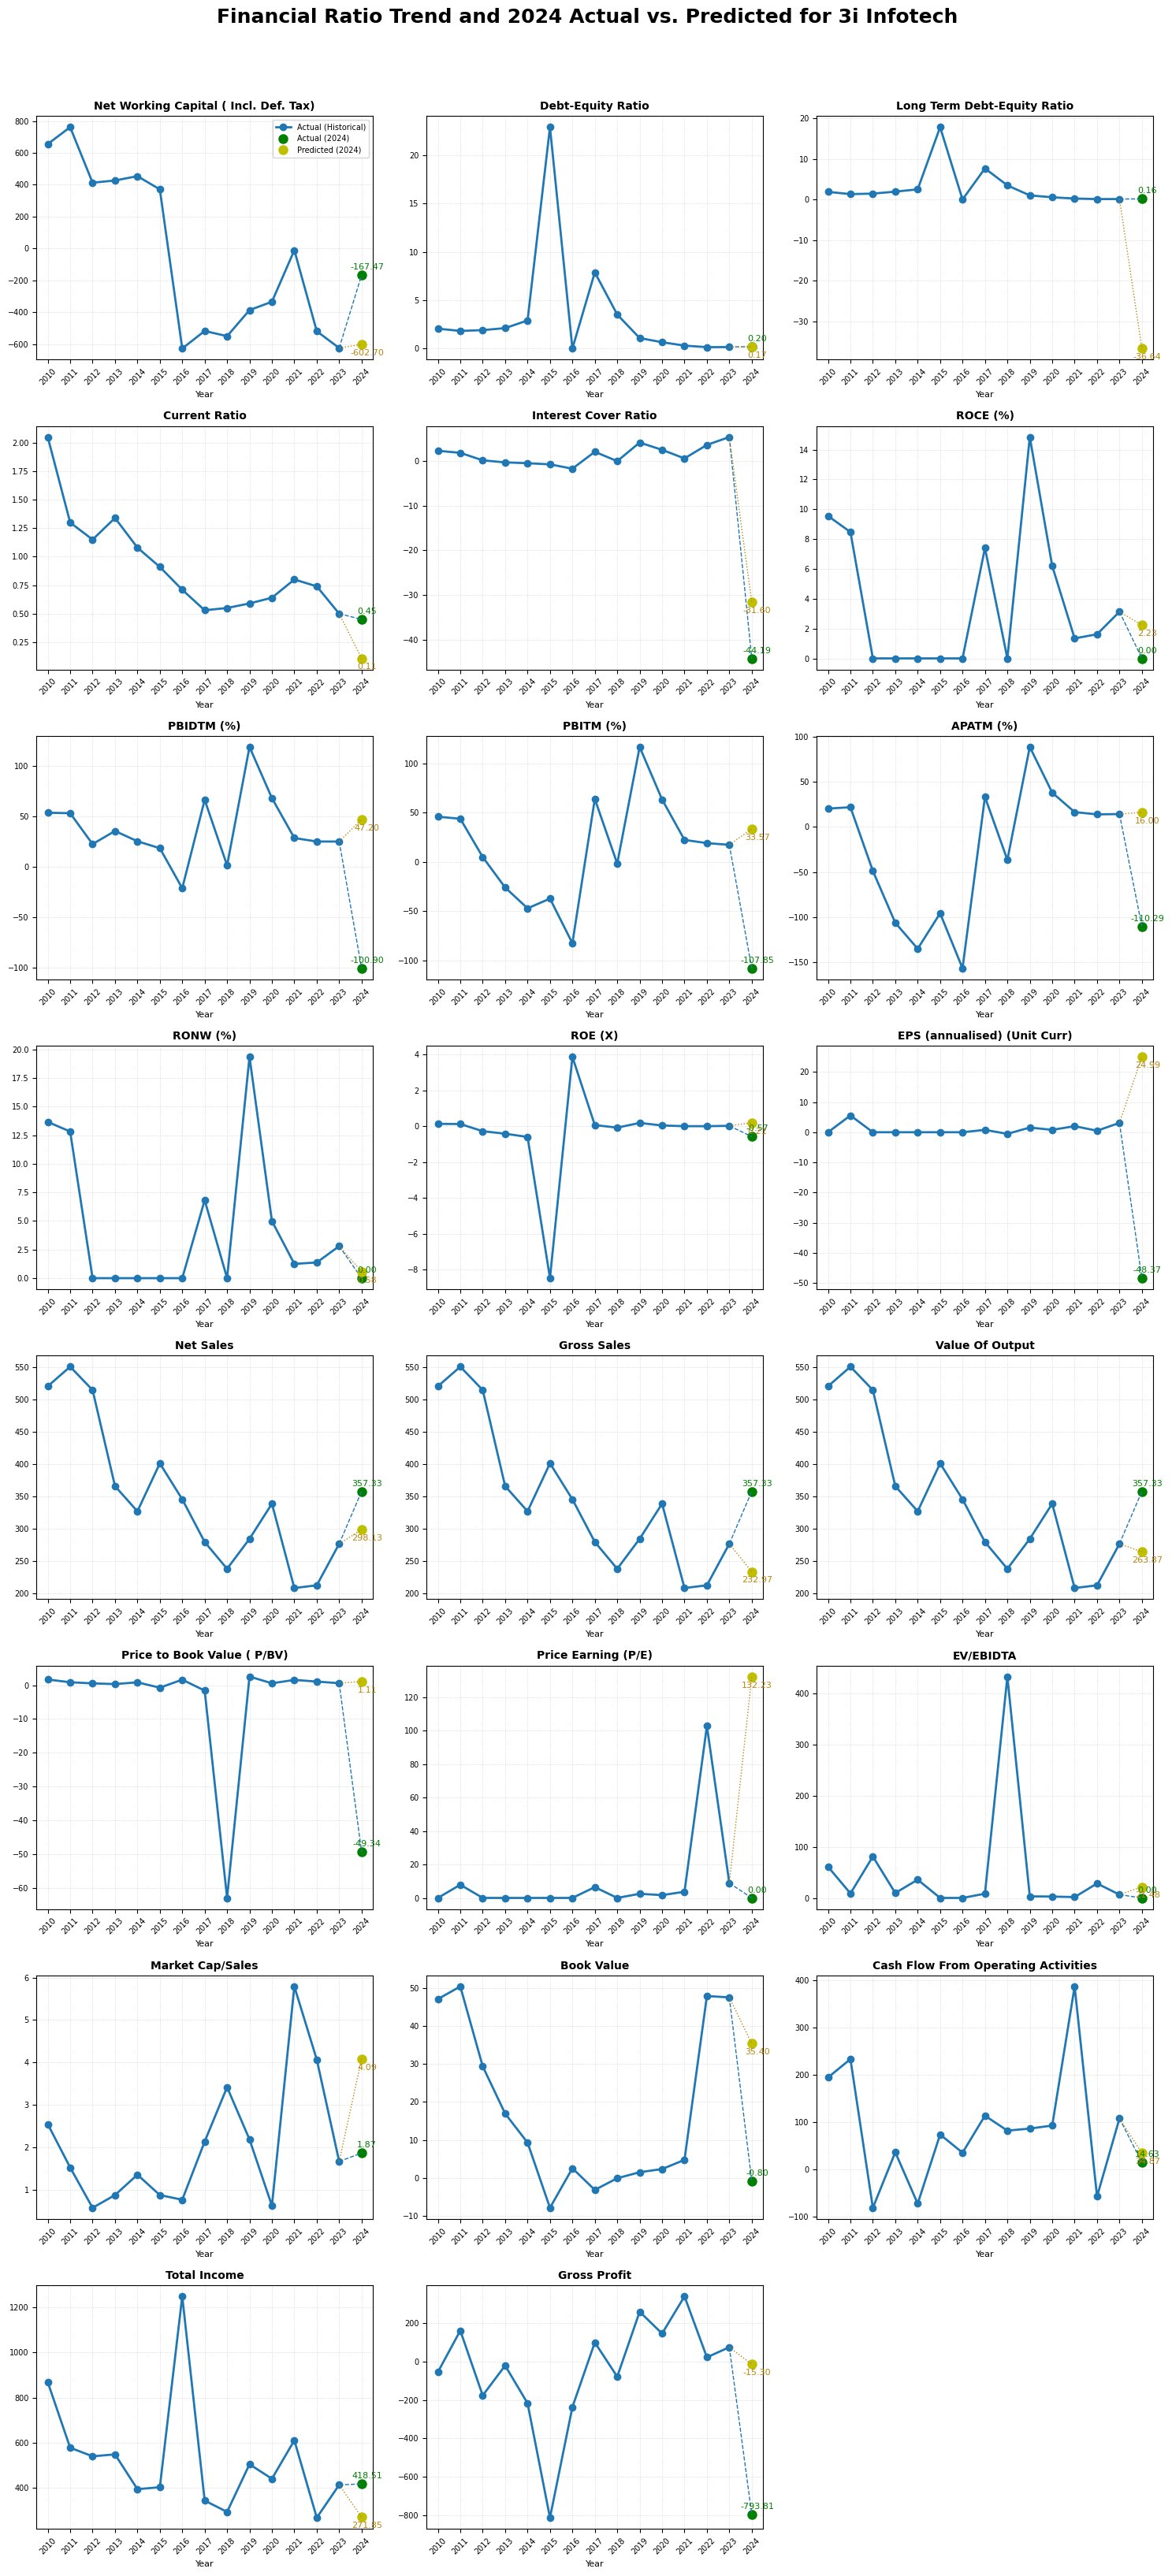


2024 comparison plotting process complete.


In [35]:
# --- Generate Plots with 2024 Actual and Predicted Values Comparison ---

print("Generating plots with 2024 actual and predicted values comparison...")

# Ensure necessary dataframes are available from previous steps
# df, predicted_2024, df_2024_actual_eval, GROUP_COLUMN, TIME_COLUMN, COMPANY_COLUMN, ratio_cols

if 'df' not in locals() or 'predicted_2024' not in locals() or 'df_2024_actual_eval' not in locals() or 'GROUP_COLUMN' not in locals() or 'TIME_COLUMN' not in locals() or 'COMPANY_COLUMN' not in locals() or 'ratio_cols' not in locals():
    print("Error: Required dataframes or variables not found for plotting.")
else:
    # Merge predicted 2024 and actual 2024 dataframes for plotting
    # Use the filtered evaluation dataframes to ensure alignment
    df_2024_comparison_plot = df_2024_actual_eval.merge(predicted_2024, left_index=True, right_index=True, how='inner', suffixes=('_actual', '_predicted'))

    # Add Company Name and Capitaline Code back for filtering and titles
    # Assuming df_2024_actual_eval still has Company Name as a column or in index
    if COMPANY_COLUMN not in df_2024_comparison_plot.columns and COMPANY_COLUMN in df_2024_actual_eval.columns:
         df_2024_comparison_plot[COMPANY_COLUMN] = df_2024_actual_eval[COMPANY_COLUMN]
    if GROUP_COLUMN not in df_2024_comparison_plot.columns and GROUP_COLUMN in df_2024_actual_eval.index.names:
         df_2024_comparison_plot.reset_index(inplace=True)


    # Get list of companies for plotting (those with both actual and predicted 2024 data)
    companies_to_plot = df_2024_comparison_plot[COMPANY_COLUMN].unique().tolist()

    if not companies_to_plot:
        print("No companies found with both actual and predicted 2024 data for plotting.")
    else:
        # For simplicity, let's plot for the first few companies or a specified target company
        # Assuming TARGET_COMPANY_NAME is still defined from previous cells
        if 'TARGET_COMPANY_NAME' in locals() or 'TARGET_COMPANY_NAME' in globals():
             companies_to_plot = [TARGET_COMPANY_NAME]
        else:
             # If TARGET_COMPANY_NAME is not defined, plot for the first company in the list
             companies_to_plot = [companies_to_plot[0]]
             print(f"TARGET_COMPANY_NAME not found. Plotting for the first company with 2024 data: {companies_to_plot[0]}")


        for company_name in companies_to_plot:
            print(f"\nGenerating plots for {company_name}...")

            # Filter 2024 comparison data for the current company
            company_2024_comparison_df = df_2024_comparison_plot[df_2024_comparison_plot[COMPANY_COLUMN] == company_name]

            if company_2024_comparison_df.empty:
                print(f"Skipping plotting for {company_name}: No 2024 comparison data found.")
                continue

            company_2024_comparison = company_2024_comparison_df.iloc[0]


            # Filter historical data for the current company
            company_data_historical = df[df[COMPANY_COLUMN] == company_name].copy()
            company_data_historical.drop_duplicates(subset=[TIME_COLUMN], keep='last', inplace=True)
            company_data_historical.sort_values(by=TIME_COLUMN, inplace=True)


            n_ratios = len(ratio_cols)
            n_cols = 3
            n_rows = int(np.ceil(n_ratios / n_cols))

            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
            axes = axes.flatten() if n_rows > 1 or n_cols > 1 else np.array([axes])

            fig.suptitle(f'Financial Ratio Trend and 2024 Actual vs. Predicted for {company_name}', fontsize=18, y=1.02, fontweight='bold')

            for i, ratio in enumerate(ratio_cols):
                ax = axes[i]

                # Plot historical data (excluding 2024)
                historical_data_plot = company_data_historical[company_data_historical[TIME_COLUMN] < 2024].dropna(subset=[ratio])
                if not historical_data_plot.empty:
                    ax.plot(historical_data_plot[TIME_COLUMN], historical_data_plot[ratio], label='Actual (Historical)', marker='o', color='#1f77b4', linewidth=2)

                # Plot 2024 Actual Value
                actual_2024_col_name = f'{ratio}_actual'
                actual_2024_value = company_2024_comparison.get(actual_2024_col_name)

                if pd.notna(actual_2024_value):
                    ax.plot(2024, actual_2024_value, 'go', label='Actual (2024)', markersize=8) # Green circle for actual 2024
                    ax.annotate(f'{actual_2024_value:.2f}', (2024, actual_2024_value), textcoords="offset points", xytext=(5,5), ha='center', fontsize=8, color='green')
                    # Draw a dashed line connecting last historical point to 2024 actual
                    if not historical_data_plot.empty:
                         last_historical_point = historical_data_plot.iloc[-1]
                         ax.plot([last_historical_point[TIME_COLUMN], 2024],
                                [last_historical_point[ratio], actual_2024_value],
                                color='#1f77b4', linestyle='--', linewidth=1)


                # Plot 2024 Predicted Value
                predicted_2024_col_name = f'{ratio}_predicted'
                predicted_2024_value = company_2024_comparison.get(predicted_2024_col_name)

                if pd.notna(predicted_2024_value):
                    ax.plot(2024, predicted_2024_value, 'yo', label='Predicted (2024)', markersize=8) # Yellow circle for predicted 2024
                    ax.annotate(f'{predicted_2024_value:.2f}', (2024, predicted_2024_value), textcoords="offset points", xytext=(5,-10), ha='center', fontsize=8, color='darkgoldenrod')
                    # Draw a dashed line connecting last historical point to 2024 predicted
                    if not historical_data_plot.empty:
                         last_historical_point = historical_data_plot.iloc[-1]
                         ax.plot([last_historical_point[TIME_COLUMN], 2024],
                                [last_historical_point[ratio], predicted_2024_value],
                                color='darkgoldenrod', linestyle=':', linewidth=1)


                ax.set_title(ratio, fontsize=10, fontweight='semibold')
                ax.set_xlabel('Year', fontsize=8)
                ax.tick_params(axis='x', rotation=45, labelsize=7)
                ax.tick_params(axis='y', labelsize=7)
                ax.grid(True, which='both', linestyle=':', linewidth=0.5, alpha=0.7)

                # Set X ticks to include all years with data
                all_years = historical_data_plot[TIME_COLUMN].tolist()
                if pd.notna(actual_2024_value) or pd.notna(predicted_2024_value):
                    all_years.append(2024)
                ax.set_xticks(sorted(list(set(all_years))))
                if all_years:
                    ax.set_xlim(min(all_years) - 0.5, max(all_years) + 0.5)


                # Add legend
                if i == 0:
                    handles, labels = ax.get_legend_handles_labels()
                    # Define the desired order
                    desired_order_labels = ['Actual (Historical)', 'Actual (2024)', 'Predicted (2024)']
                    legend_dict = dict(zip(labels, handles))
                    ordered_handles = [legend_dict[label] for label in desired_order_labels if label in legend_dict]
                    ordered_labels = [label for label in desired_order_labels if label in legend_dict]
                    ax.legend(ordered_handles, ordered_labels, fontsize=7, loc='best')


            # Hide any unused subplots
            for j in range(i + 1, n_rows * n_cols):
                if j < len(axes):
                    fig.delaxes(axes[j])

            plt.tight_layout()

            # Save the plot
            plot_filename_2024_comparison = f"{company_name}_2024_actual_vs_predicted_XGBoost_plots.png"
            plt.savefig(plot_filename_2024_comparison, bbox_inches='tight')

            print(f"\nPlots for {company_name} saved to {plot_filename_2024_comparison}. The charts should be displayed below in Colab.")
            plt.show()

print("\n2024 comparison plotting process complete.")

In [36]:
# --- Calculate and Display Additional Evaluation Metrics ---

print("\nCalculating and displaying additional evaluation metrics for 2024 predictions...")

# Ensure necessary dataframes are available from previous steps
# predicted_2024, df_2024_actual_eval, ratio_cols

if 'predicted_2024' not in locals() or 'df_2024_actual_eval' not in locals() or 'ratio_cols' not in locals():
    print("Error: Required dataframes or variables (predicted_2024, df_2024_actual_eval, ratio_cols) not found for calculating metrics.")
else:
    evaluation_metrics = {}

    # Ensure df_2024_actual_eval has the same index as predicted_2024 for reliable comparison
    common_indices_for_metrics = predicted_2024.index.intersection(df_2024_actual_eval.index)
    predicted_2024_aligned = predicted_2024.loc[common_indices_for_metrics]
    df_2024_actual_eval_aligned = df_2024_actual_eval.loc[common_indices_for_metrics]


    if common_indices_for_metrics.empty:
        print("No common companies found with both actual and predicted 2024 data for metric calculation.")
    else:
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

        for target_col in ratio_cols:
            y_true = df_2024_actual_eval_aligned[target_col]
            y_pred = predicted_2024_aligned[target_col]

            # Drop NaN values from both true and predicted for metric calculation
            valid_mask = np.isfinite(y_true) & np.isfinite(y_pred)
            y_true_filtered = y_true[valid_mask]
            y_pred_filtered = y_pred[valid_mask]

            if not y_true_filtered.empty:
                # Calculate metrics
                mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
                mse = mean_squared_error(y_true_filtered, y_pred_filtered)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_true_filtered, y_pred_filtered)

                evaluation_metrics[target_col] = {
                    'MAE': mae,
                    'MSE': mse,
                    'RMSE': rmse,
                    'R-squared': r2
                }
            else:
                evaluation_metrics[target_col] = {
                    'MAE': np.nan,
                    'MSE': np.nan,
                    'RMSE': np.nan,
                    'R-squared': np.nan
                }

        print("\nModel Evaluation Metrics (2024 Predictions vs. Actuals):")
        # Print headers
        print(f"{'Ratio':<40} | {'MAE':<10} | {'MSE':<10} | {'RMSE':<10} | {'R-squared':<10}")
        print("-" * 90)

        # Print metrics for each ratio
        for ratio, metrics in evaluation_metrics.items():
            print(f"{ratio:<40} | {metrics['MAE']:<10.2f} | {metrics['MSE']:<10.2f} | {metrics['RMSE']:<10.2f} | {metrics['R-squared']:<10.2f}")

print("\nAdditional evaluation metrics calculation complete.")


Calculating and displaying additional evaluation metrics for 2024 predictions...

Model Evaluation Metrics (2024 Predictions vs. Actuals):
Ratio                                    | MAE        | MSE        | RMSE       | R-squared 
------------------------------------------------------------------------------------------
Net Working Capital ( Incl. Def. Tax)    | 365.00     | 8040613.42 | 2835.60    | 0.97      
Debt-Equity Ratio                        | 0.94       | 39.68      | 6.30       | 0.15      
Long Term Debt-Equity Ratio              | 4.40       | 3114.70    | 55.81      | -199.58   
Current Ratio                            | 9.47       | 5270.69    | 72.60      | 0.30      
Interest Cover Ratio                     | 62.14      | 252385.87  | 502.38     | 0.49      
ROCE (%)                                 | 7.20       | 443.27     | 21.05      | -0.16     
PBIDTM (%)                               | 284.57     | 68535742.79 | 8278.63    | -265.21   
PBITM (%)               

In [37]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Store errors for each ratio
mse_scores = {}

print("Training models and predicting 2025 values for all financial ratios...")

for target_col in ratio_cols:
    # 1️⃣ Select target and drop missing rows
    y_train = df_model[target_col]
    mask = y_train.notna()
    X_train = df_model.loc[mask, feature_cols]
    y_train = y_train[mask]

    # 2️⃣ Define model pipeline
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('xgb', XGBRegressor(
            random_state=42,
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4
        ))
    ])

    # 3️⃣ Train the model
    model.fit(X_train, y_train)

    # 4️⃣ Evaluate training performance (you can also do cross-validation)
    y_pred = model.predict(X_train)
    mse = mean_squared_error(y_train, y_pred)
    rmse = np.sqrt(mse)

    # Store score
    mse_scores[target_col] = mse

    print(f"{target_col:<30} | RMSE: {rmse:.4f}")

# 5️⃣ Compute overall average errors
overall_mse = np.mean(list(mse_scores.values()))
overall_rmse = np.sqrt(overall_mse)

print("\n===========================")
print(f"Overall MSE:  {overall_mse:.4f}")
print(f"Overall RMSE: {overall_rmse:.4f}")
print("===========================")


Training models and predicting 2025 values for all financial ratios...
Net Working Capital ( Incl. Def. Tax) | RMSE: 915.0898
Debt-Equity Ratio              | RMSE: 3.4038
Long Term Debt-Equity Ratio    | RMSE: 69.8956
Current Ratio                  | RMSE: 35.5337
Interest Cover Ratio           | RMSE: 289.7247
ROCE (%)                       | RMSE: 15.3235
PBIDTM (%)                     | RMSE: 904.9111
PBITM (%)                      | RMSE: 943.5542
APATM (%)                      | RMSE: 1277.9510
RONW (%)                       | RMSE: 37.8273
ROE (X)                        | RMSE: 1.1784
EPS (annualised) (Unit Curr)   | RMSE: 162.0272
Net Sales                      | RMSE: 1618.1277
Gross Sales                    | RMSE: 1766.3340
Value Of Output                | RMSE: 1735.4308
Price to Book Value ( P/BV)    | RMSE: 16.1384
Price Earning (P/E)            | RMSE: 271.3515
EV/EBIDTA                      | RMSE: 35.9415
Market Cap/Sales               | RMSE: 171.9176
Book Value      

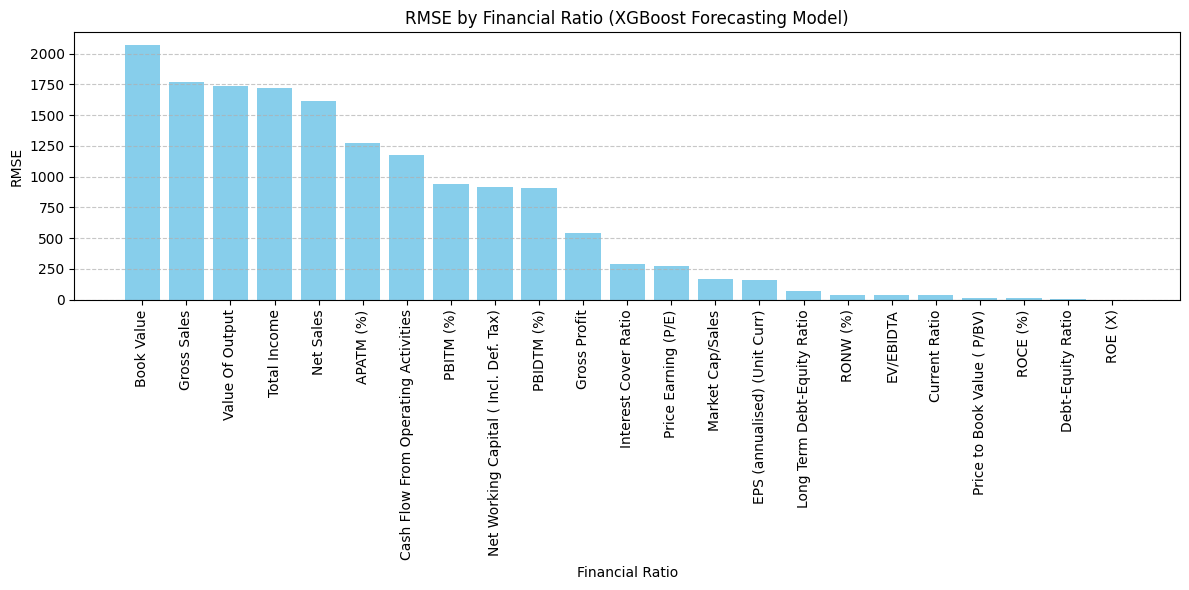

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Convert MSE to RMSE for easier interpretation
rmse_scores = {col: np.sqrt(mse) for col, mse in mse_scores.items()}

# Sort ratios by RMSE (worst to best)
sorted_rmse = dict(sorted(rmse_scores.items(), key=lambda x: x[1], reverse=True))

# Plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_rmse)), list(sorted_rmse.values()), color='skyblue')
plt.xticks(range(len(sorted_rmse)), list(sorted_rmse.keys()), rotation=90)
plt.title("RMSE by Financial Ratio (XGBoost Forecasting Model)")
plt.ylabel("RMSE")
plt.xlabel("Financial Ratio")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [39]:
# Filter the prediction_output DataFrame for the target company
target_company_prediction = prediction_output[prediction_output['Company Name'] == TARGET_COMPANY_NAME].copy()

# Save the filtered DataFrame to a CSV file
plot_filename_2025_prediction = f"predicted_2025_ratios.csv"
target_company_prediction.to_csv(plot_filename_2025_prediction, index=False)

print(f"Predicted 2025 ratios for {TARGET_COMPANY_NAME} saved to {plot_filename_2025_prediction}")

Predicted 2025 ratios for 3i Infotech saved to predicted_2025_ratios.csv


In [40]:
import pandas as pd

# Load your 2025 ratios

df = pd.read_csv("predicted_2025_ratios.csv")

# Define thresholds (same as in your notebook)

threshold_gt = {
"Net Working Capital ( Incl. Def. Tax)": 0,
"Current Ratio": 1.5,
"Interest Cover Ratio": 3,
"ROCE (%)": 15,
"PBIDTM (%)": 10,
"PBITM (%)": 10,
"APATM (%)": 8,
"RONW (%)": 12,
"ROE (X)": 12,
"EPS (annualised) (Unit Curr)": 5,
"Cash Flow From Operating Activities": 0,
}

threshold_lt = {
"Debt-Equity Ratio": 1.5,
"Long Term Debt-Equity Ratio": 1,
"Price to Book Value ( P/BV)": 3,
"Price Earning (P/E)": 15,
"EV/EBIDTA": 10,
"Market Cap/Sales": 2,
}

# Create flags for each condition

for feature, threshold in threshold_gt.items():
    col = f"Predicted {feature} (2025)"
    if col in df.columns:
        df[f"{feature}_Flag"] = (df[col] > threshold).astype(int)

for feature, threshold in threshold_lt.items():
    col = f"Predicted {feature} (2025)"
    if col in df.columns:
        df[f"{feature}_Flag"] = (df[col] < threshold).astype(int)

# Calculate an overall performance score = sum of all flags

flag_cols = [col for col in df.columns if col.endswith("_Flag")]
df["Performance_Score_2025"] = df[flag_cols].sum(axis=1)

# Define label: 1 = strong performer, 0 = weak

df["Predicted_Performance_Label_2025"] = (df["Performance_Score_2025"] >= len(flag_cols) * 0.6).astype(int)

# Keep only relevant columns for output

output = df[["Company Name", "Performance_Score_2025", "Predicted_Performance_Label_2025"]]
output.to_csv("predicted_2025_company_performance.csv", index=False)

print(output)

  Company Name  Performance_Score_2025  Predicted_Performance_Label_2025
0  3i Infotech                       7                                 0
